# Dogs vs Cats from Scratch

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

TODO:
1. [Create validation and sample sets](#Create-validation-and-sample-sets)
2. [Rearrange image files into new directories](#Rearrange-image-files-into-new-directories)
3. [Fine-tuning](#Fine-tuning)
4. [Training](#Training)

In [1]:
%matplotlib inline
import os, sys

In [2]:
current_dir = os.getcwd()
data_dir    = current_dir + '/data/redux'

## Create validation and sample sets

In [ ]:
%cd $data_dir

In [ ]:
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

In [54]:
import numpy as np
from glob import glob
from shutil import copyfile

In [ ]:
%rm valid -R
%rm sample -R
%rm test -R

In [ ]:
%cd $data_dir/train

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], data_dir + '/valid/' + shuf[i])

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], data_dir + '/sample/train/' + shuf[i])

In [ ]:
%cd $data_dir/valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], data_dir + '/sample/valid/' + shuf[i])

In [ ]:
%cd $data_dir/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

## Rearrange image files into new directories

In [ ]:
%cd $data_dir/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
%cd $data_dir/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
%cd $data_dir/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
%cd $data_dir/test
%mv *.jpg unknown/

## Fine-tuning

In [12]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

In [13]:
vgg = VGG16(weights='imagenet', include_top=True)

In [14]:
vgg.layers.pop()

In [15]:
for layer in vgg.layers: layer.trainable=False

In [16]:
x = Dense(2, activation='softmax', name='predictions')(vgg.layers[-1].output)

In [17]:
model = Model(input=vgg.input, output=x)

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  0           input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [19]:
lr = 0.01

In [30]:
model.compile(
    optimizer=Adam(lr=lr), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.load_weights(results_path + 'ft3.h5')

## Training

In [31]:
%cd $data_dir

/home/ubuntu/nbs/lesson2/data/redux


In [32]:
#path         = data_dir + '/'
path         = data_dir + '/' + '/sample/'
test_path    = data_dir + '/test/'
results_path = data_dir + '/results/'
train_path   = path + '/train/'
valid_path   = path + '/valid/'

In [33]:
from keras.preprocessing import image

def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(
        path, 
        target_size=(224,224), 
        class_mode=class_mode, 
        shuffle=shuffle, 
        batch_size=batch_size)

In [34]:
batch_size=64

In [38]:
nb_epoch=3

In [ ]:
batches = get_batches(train_path, batch_size=batch_size)

In [ ]:
val_batches = get_batches(valid_path, batch_size=batch_size)

In [ ]:
for epoch in range(nb_epoch):    
    model.fit_generator(batches, 
        samples_per_epoch=batches.nb_sample, 
        nb_epoch=nb_epoch,
        validation_data=val_batches, 
        nb_val_samples=val_batches.nb_sample)    
    model.save_weights(results_path + 'ft%d.h5' % epoch)

In [ ]:
# model.load_weights(results_path + 'ft3.h5')

## Generate Predictions

In [43]:
test_batches = get_batches(test_path, shuffle=False, batch_size=batch_size * 2, class_mode=None)

Found 12500 images belonging to 1 classes.


In [44]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [45]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [46]:
filenames = test_batches.filenames

In [47]:
# Save predictions
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [49]:
# Load predictions
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [51]:
isdog = preds[:, 1]

In [52]:
# Round down our edge predictions for log loss
isdog = isdog.clip(min=0.05, max=0.95)

In [55]:
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [56]:
# Join columns
subm = np.stack([ids, isdog], axis=1)

## Submit to Kaggle

In [84]:
%cd $current_dir

/home/ubuntu/nbs/lesson2


In [85]:
subm_filename = 'subm.csv'
np.savetxt(subm_filename, subm, fmt='%d,%.5f', header='id,label', comments='')

In [86]:
from IPython.display import FileLink

In [87]:
FileLink(subm_filename)

/home/ubuntu/nbs/lesson2/subm.csv

## Visualize Log Loss 

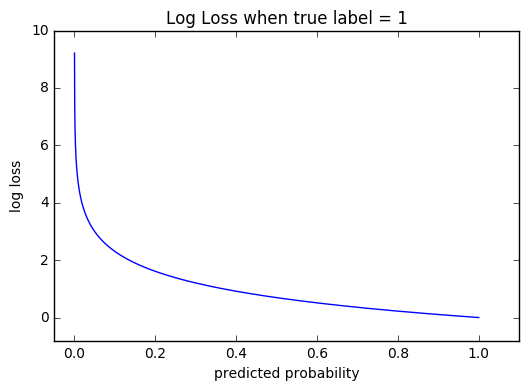

In [88]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()